<a href="https://colab.research.google.com/github/Pepe-Padilla/deep-learning/blob/main/Modelo2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo2D - DeepLearning


### Indice
1. Introducción
2. Importación y Normalización de datos
3. Entrenamiento
4. Gráfica de Perdidas
5. Test
6. Concluciones

##  1. Introducción

**Práctica DL** - Ejercicio de Bootcamp Inteligencia Artificial Full Stack Edición III

Este proyecto es un entregable para la práctica del Master Bootcamp Inteligencia Artificial Full Stack Edición III realizado por el centro de formación [@Keepcoding](https://github.com/KeepCoding)

---

El objetivo de este trabajo consiste en resolver un problema del mundo real empleando para ello técnicas vistas durante las sesiones de dicho módulo. En concreto, se trabajará en predecir la condición médica sufrida por una cohorte de pacientes a partir de las diferentes fuentes de información disponibles (imágenes y datos tabulares).

Las imagenes deben entrenar y obtener una de los siguientes respuestas:

| Enfermedad | Descripción | Código | Indice en salida |
|------------|-------------|--------|------------------|
| Actinic keratoses y carcinoma de células escamosas | Tipo de cáncer de piel | akiec | 0 |
| Nevus melanocítico | Lesión benigna común | nv | 1 |
| Melanoma | Tipo de cáncer de piel agresivo | mel | 2 |
| Lesiones benignas de queratosis | Incluyen lentigo solar y queratosis seborreica | bkl | 3 |
| Dermatofibroma | Lesión benigna del tejido fibroso | df | 4 |
| Vasculares | Lesiones vasculares como hemangiomas | vasc | 5 |
| Lesión de células basales | Un tipo de cáncer de piel menos agresivo que el melanoma | bcc | 6 |

---

Para el modelo2D Se trabajará con imagenes, y al menos debe exisistir una red convolucional

## 2. Importación y Normalización de datos

### 2.1 Imports

In [1]:
# 1. Primero las importaciones que necesitaremos
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.optimizers import Adam

### 2.2 Obtención de datos

In [2]:
# 2. Obtención de datos
#dataframe = pd.read_csv("/content/HAM10000_metadata.csv", usecols=[1], engine='python', skipfooter=3)
#df = dataframe.values
df_label = pd.read_csv("/content/HAM10000_metadata.csv", sep=",")
df_image = pd.read_csv("/content/hnmist_28_28_RGB.csv", sep=",")


### 2.3 Inspección de elementos

In [3]:
# 2. Inspección de los datos
print(df_image.head())
print(df_image.info())
print(df_label.head())
print(df_label.info())

# 3. Preprocesamiento
# Separación de características e imágenes
X = df_image.values  # Extraemos los valores de píxeles
X = X.reshape(-1, 28, 28, 3)  # Reestructuramos a formato de imagen (28x28x3)
X = X.astype(np.float32) / 255.0  # Normalización de valores RGB
y_coll = df_label['dx']  # Extraemos las etiquetas de diagnóstico

# One-Hot Encoding para la variable de salida
y = pd.get_dummies(y_coll).values



   pixel0000  pixel0001  pixel0002  pixel0003  ...  pixel2348  pixel2349  pixel2350  pixel2351
0        192        153        193        195  ...        166        185        154        177
1         25         14         30         68  ...         28         25         14         27
2        192        138        153        200  ...        142        136        104        117
3         38         19         30         95  ...         17         25         12         15
4        158        113        139        194  ...        149        109         78         92

[5 rows x 2352 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Columns: 2352 entries, pixel0000 to pixel2351
dtypes: int64(2352)
memory usage: 179.7 MB
None
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl 

### 2.4 Separación de datos

In [4]:
# 4. Separación de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=True, test_size=0.15, random_state=42)

# 5. Verificación de normalización
print("Rango de valores normalizados en X:", X_train.min(), "a", X_train.max())
print("Formato de salida Y:", y_train.shape)

Rango de valores normalizados en X: 0.0 a 1.0
Formato de salida Y: (6810, 7)


### 2.5 Verificación

In [5]:
# 5. Verificación de normalización
y_traindf = pd.DataFrame(y_train)

print(y_traindf.describe())
print(X_train.shape)

            0      1      2      3      4     5      6
count    6810   6810   6810   6810   6810  6810   6810
unique      2      2      2      2      2     2      2
top     False  False  False  False  False  True  False
freq     6583   6455   6079   6734   6063  4566   6702
(6810, 28, 28, 3)


## 3. Entrenamiento

In [13]:
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.constraints import max_norm

# 6. Definición del modelo CNN con Dropout
P = 0.20
n_epochs = 50

# Primer capa
inputs = Input(shape=(28, 28, 3))
input_step = Conv2D(128, kernel_size=(3, 3), input_shape=(28, 28, 3))(inputs)
input_step = BatchNormalization()(input_step)
input_step = Activation('relu')(input_step)
input_step = MaxPooling2D(pool_size=(2, 2))(input_step)
input_step = Dropout(P)(input_step)

# Definimos una segunda capa convolucional
input_step = Conv2D(128, kernel_size=(3, 3))(input_step)
input_step = BatchNormalization()(input_step)
input_step = Activation('relu')(input_step)
input_step = MaxPooling2D(pool_size=(2, 2))(input_step)
input_step = Dropout(P)(input_step)

# Definimos una tercera capa convolucional
input_step = Conv2D(128, kernel_size=(3, 3))(input_step)
input_step = BatchNormalization()(input_step)
input_step = Activation('relu')(input_step)
input_step = MaxPooling2D(pool_size=(2, 2))(input_step)
input_step = Dropout(P)(input_step)

# Añadimos nuestro clasificador
input_step = GlobalAveragePooling2D()(input_step)
input_step = Dense(1024, activation='relu', kernel_constraint=max_norm(3.0))(input_step)
input_step = Dropout(P)(input_step)

# Definción de los outputs
outputs = Dense(y.shape[1], activation='softmax')(input_step)

# Definimos el modelo
model = Model(inputs=inputs, outputs=outputs)

# Compilamos el modelo
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(1.5e-5),
              metrics=['accuracy'])

# 8. Entrenamiento del modelo
H = model.fit(X_train, y_train,
          batch_size=128,
          shuffle=True,
          epochs=n_epochs,
          validation_data=(X_val, y_val))

# 9. Evaluación del modelo
scores = model.evaluate(X_test, y_test)
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])




/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.3767 - loss: 1.7092 - val_accuracy: 0.6664 - val_loss: 1.7712
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6692 - loss: 1.1123 - val_accuracy: 0.6664 - val_loss: 1.6359
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6716 - loss: 1.0060 - val_accuracy: 0.6664 - val_loss: 1.5598
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6832 - loss: 0.9434 - val_accuracy: 0.6664 - val_loss: 1.5239
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6933 - loss: 0.9201 - val_accuracy: 0.6589 - val_loss: 1.5035
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6856 - loss: 0.9129 - val_accuracy: 0.6414 - val_loss: 1.4901
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6878 - loss: 0.9058 - val_accuracy: 0.5849 - val_loss: 1.4689
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6895 - loss: 0.9006 - val_accuracy: 0.5715 -

## 4. Gráfica de Perdidas

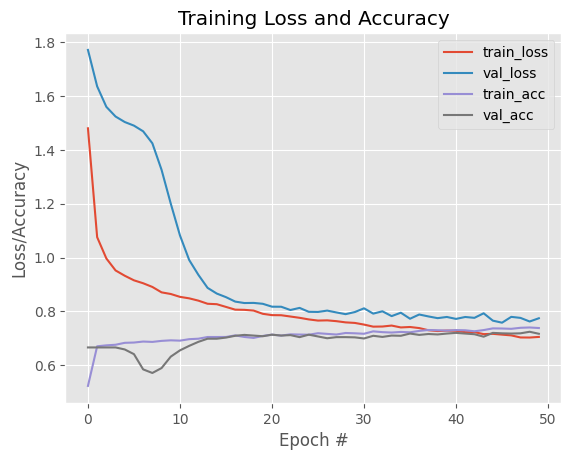

In [14]:
# veamos nuestra función de pérdidas con respecto a las épocas ejecutadas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [15]:
# Guardamos el resultado
model.save("/content/2d_model.keras")

## 5. Concluciones

In [16]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 28, 28, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 26, 26, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 11, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 3, 3, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,317,143 (5.02 MB)

 Trainable params: 438,791 (1.67 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 877,584 (3.35 MB)

El objetivo para esta parte del modelo 2D era la predicicón con imagenes, Se utilizó una red neuronal convolucional (CNN). En particular, se implementó una arquitectura con múltiples capas convolucionales seguidas de Batch Normalization, ReLU y Dropout para mejorar la capacidad de generalización y evitar el overfitting. Usé el GlobalAveragePooling2D para reducir la dimensionalidad antes de la capa densa final, mejorando la eficiencia computacional. Al igual que con 1D ReLU com función no líneal para mantener el rango entre 0 y 1.

El modelo mostró una tendencia esperada en la gráfica de loss y accuracy, aunque se observaron picos anómalos en ambas métricas. Puede ser por el tamaño del batch o por el tamaño de la muestra, también podría ser por la taza de aprendizaje (aunque use una pequeña)

Si se dispusiera de más tiempo, se podrían aplicar los siguientes enfoques:

Tamaño del Batch Ajustado: Probar valores más pequeños (como 64 o 32) para reducir la variabilidad de cada batch. Implementar una estrategia de reducción de la tasa de aprendizaje cuando la loss deje de mejorar. Además de Dropout, podría incluir una penalización en los pesos para evitar Overfitting.

En general, la implementación de CNN con Dropout ha sido efectiva, aunque con más recursos y ajustes podría mejorar aún más su precisión y estabilidad.